In [3]:
pip install yfinance pandas matplotlib numpy

Note: you may need to restart the kernel to use updated packages.


In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# define the ticker for BTC
ticker = 'BTC-USD'

# download the data from yfinance
data = yf.download(ticker, start='2022-01-01', end='2023-01-01')

[*********************100%***********************]  1 of 1 completed


In [5]:
# calculate the RSI
delta = data['Close'].diff(1)
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
data['RSI'] = 100 - (100 / (1 + rs))


In [6]:
# define buy and sell signals based on the RSI thresholds
data['Buy_Signal'] = np.where(data['RSI'] < 30, 1, 0)  # Buy when RSI < 30
data['Sell_Signal'] = np.where(data['RSI'] > 70, 1, 0)  # Sell when RSI > 70

In [7]:
# Initialize variables for backtesting
initial_capital = 10000  # Starting with $10,000
capital = initial_capital
position = 0  # No initial position
portfolio_value = []  # Track portfolio value over time

# Buy-and-hold baseline (for comparison)
buy_and_hold_position = capital / data['Close'].iloc[0]  # Buy Bitcoin at the start
buy_and_hold_value = []  # Track buy-and-hold portfolio value over time

In [8]:
# Backtest the RSI strategy
for i, row in data.iterrows():
    # Calculate buy-and-hold value (for comparison)
    buy_and_hold_value.append(buy_and_hold_position * row['Close'])

    # RSI strategy: Buy if RSI < 30, Sell if RSI > 70
    if row['Buy_Signal'] == 1 and position == 0:  # Buy condition
        position = capital / row['Close']  # Buy Bitcoin with all available capital
        capital = 0  # All capital is converted to Bitcoin

    elif row['Sell_Signal'] == 1 and position > 0:  # Sell condition
        capital = position * row['Close']  # Sell Bitcoin, convert to cash
        position = 0  # No Bitcoin held after selling

    # Track portfolio value (cash + value of Bitcoin held)
    if position > 0:
        portfolio_value.append(position * row['Close'])  # Value of Bitcoin held
    else:
        portfolio_value.append(capital)  # Cash when no Bitcoin held

# Store the portfolio values in the data
data['RSI_Portfolio_Value'] = portfolio_value

In [9]:
# Calculate daily returns for Sharpe Ratio calculation
data['RSI_Daily_Returns'] = data['RSI_Portfolio_Value'].pct_change()
data['Buy_Hold_Daily_Returns'] = pd.Series(buy_and_hold_value).pct_change()

# Sharpe Ratio (annualized)
sharpe_ratio_rsi = (data['RSI_Daily_Returns'].mean() / data['RSI_Daily_Returns'].std()) * np.sqrt(252)
sharpe_ratio_buy_hold = (data['Buy_Hold_Daily_Returns'].mean() / data['Buy_Hold_Daily_Returns'].std()) * np.sqrt(252)

# Maximum Drawdown
def max_drawdown(portfolio_values):
    cumulative_returns = (1 + portfolio_values.pct_change()).cumprod()
    peak = cumulative_returns.cummax()
    drawdown = (cumulative_returns - peak) / peak
    return drawdown.min()

max_drawdown_rsi = max_drawdown(pd.Series(portfolio_value))
max_drawdown_buy_hold = max_drawdown(pd.Series(buy_and_hold_value))

# Print performance metrics
print(f"Final RSI Strategy Portfolio Value: ${portfolio_value[-1]:.2f}")
print(f"Final Buy-and-Hold Portfolio Value: ${buy_and_hold_value[-1]:.2f}")
print(f"RSI Strategy Sharpe Ratio: {sharpe_ratio_rsi:.2f}")
print(f"Buy-and-Hold Sharpe Ratio: {sharpe_ratio_buy_hold:.2f}")
print(f"RSI Strategy Maximum Drawdown: {max_drawdown_rsi:.2%}")
print(f"Buy-and-Hold Maximum Drawdown: {max_drawdown_buy_hold:.2%}")

Final RSI Strategy Portfolio Value: $6929.77
Final Buy-and-Hold Portfolio Value: $3470.04
RSI Strategy Sharpe Ratio: -0.30
Buy-and-Hold Sharpe Ratio: nan
RSI Strategy Maximum Drawdown: -55.34%
Buy-and-Hold Maximum Drawdown: -66.74%


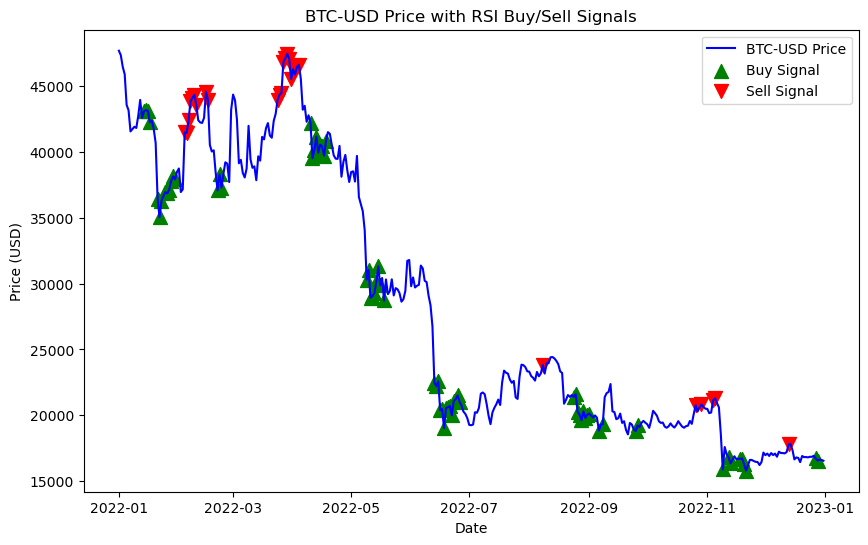

In [10]:
# Plot 1: Bitcoin Price and Buy/Sell Signals
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['Close'], label='BTC-USD Price', color='blue')
plt.scatter(data.index[data['Buy_Signal'] == 1], data['Close'][data['Buy_Signal'] == 1], label='Buy Signal', marker='^', color='green', s=100)
plt.scatter(data.index[data['Sell_Signal'] == 1], data['Close'][data['Sell_Signal'] == 1], label='Sell Signal', marker='v', color='red', s=100)
plt.title(f'{ticker} Price with RSI Buy/Sell Signals')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend(loc='best')

# Save the plot
plt.savefig('BTC_Price_Buy_Sell_Signals.png')

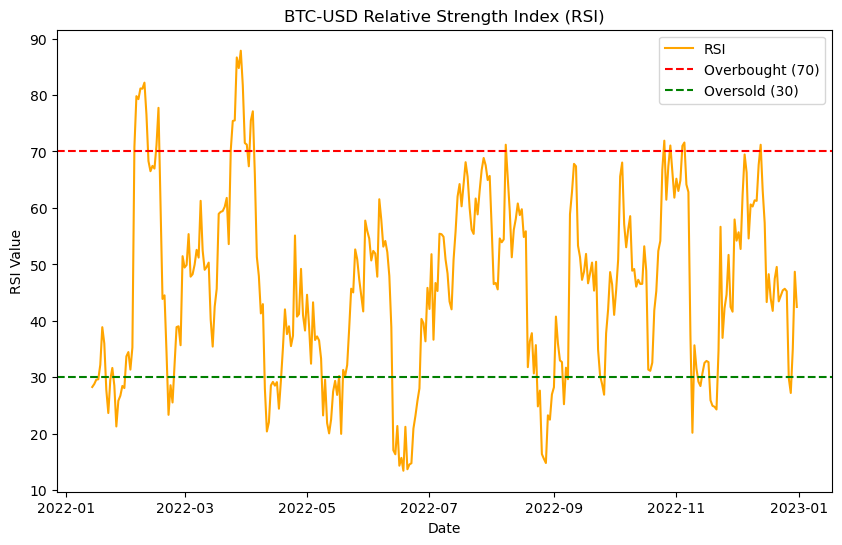

In [30]:
# Plot 2: RSI with Overbought/Oversold Levels
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['RSI'], label='RSI', color='orange')
plt.axhline(70, linestyle='--', color='red', label='Overbought (70)')
plt.axhline(30, linestyle='--', color='green', label='Oversold (30)')
plt.title(f'{ticker} Relative Strength Index (RSI)')
plt.xlabel('Date')
plt.ylabel('RSI Value')
plt.legend(loc='best')

# Save the plot
plt.savefig('BTC_RSI_Levels.png')


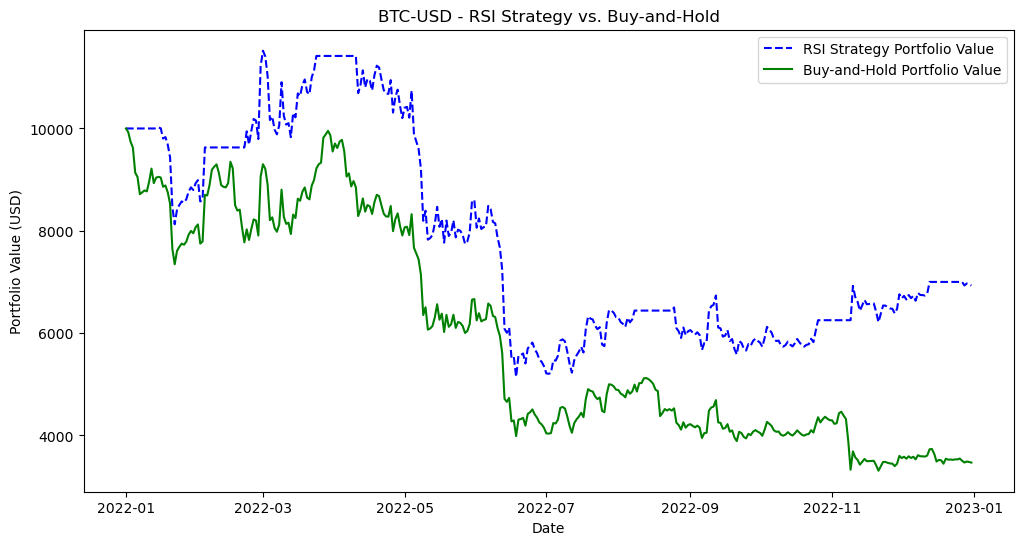

<Figure size 640x480 with 0 Axes>

In [31]:
# Plot 3: Strategy vs. Buy-and-Hold Portfolio Value
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['RSI_Portfolio_Value'], label='RSI Strategy Portfolio Value', linestyle='--', color='blue')
plt.plot(data.index, buy_and_hold_value, label='Buy-and-Hold Portfolio Value', color='green')
plt.title(f'{ticker} - RSI Strategy vs. Buy-and-Hold')
plt.xlabel('Date')
plt.ylabel('Portfolio Value (USD)')
plt.legend(loc='best')
plt.show()
plt.savefig('BTC_RSI_Strategy_vs_Buy_Hold.png')
